In [1]:
import copy
import numpy as np
import os
import verdict

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec
import matplotlib.transforms as transforms

In [3]:
import analysis_config

In [4]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.worldline_set as a_w_set
import linefinder.analyze_data.plot_worldlines as p_worldlines

In [5]:
import linefinder.utils.presentation_constants as p_constants
import linefinder.utils.file_management as file_management
import linefinder.config as linefinder_config

In [6]:
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.utils.astro as astro_utils
import galaxy_dive.utils.utilities as utilities
import galaxy_dive.utils.executable_helpers as exec_helpers
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.plot_data.qual_colormaps as qual_colormaps

# Load Data

In [7]:
do_calculation = True

In [8]:
snum, galdef = exec_helpers.choose_config_or_commandline(
    [ analysis_config.SNUM, analysis_config.GALDEF ]
)
print( 'Using snum {}, galdef {}'.format( snum, galdef ) )

Using snum 172, galdef 


In [9]:
tag_tail = '_CGM_snum{}'.format( snum )

In [10]:
ahf_index = 600

In [11]:
ind = ahf_index - snum

In [12]:
# Load the a helper for loading files easily
file_manager = file_management.FileManager( project='CGM_fate' )

In [13]:
defaults, variations = file_manager.get_linefinder_analysis_defaults_and_variations(
    tag_tail, 
    sim_names = analysis_config.SIM_NAMES,
    galdef = galdef,
)

In [14]:
w_set = a_w_set.WorldlineSet( defaults, variations )

## Get Processed Data

In [15]:
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_FATE )
classification_list.append( 'is_in_CGM' )
classification_list.append( 'is_in_CGM_not_sat' )

In [16]:
if do_calculation:
    
    data_keys = [ 'T', 'Z_asplund', 'M' ]
    
    # Prep the Data Structure
    data = {}
    for data_key in data_keys:
        data[data_key] = {}
        for classification in classification_list:
            data[data_key][classification] = {}

    # Get the data
    for sim_name in w_set.keys():

        print( sim_name )

        for classification in classification_list:

            w = w_set[sim_name].data_object

            w.mask_data( 'PType', data_value=0 )
            w.mask_data( 'is_in_CGM_not_sat', data_value=True )

            for data_key in data_keys:
                data[data_key][classification][sim_name] = w.get_selected_data(
                    data_key,
                    sl = (slice(None),ind),
                    classification = classification
                )

        w.clear_data()    

m10q
m10y
m10z
m11q
m11v
m11a
m11b
m11c
m12i


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


m12f
m12m
m11d_md
m11e_md
m11h_md
m11i_md
m12b_md
m12c_md
m12z_md
m12r_md
m12w_md


#### Halo Masses

In [17]:
if do_calculation:
    w_set.data_object.retrieve_halo_data()
    halo_masses = w_set.m_vir.inner_item( snum )

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Checking data object.
Attribute m_vir not found in plotting object. Ch

#### Save and load results

In [18]:
savefile = os.path.join(
    file_manager.project_parameters['output_data_dir'],
    'cgm_fates_temps_and_mets_snum{}.hdf5'.format( snum ),
)

In [19]:
if do_calculation:
    
    data = verdict.Dict( data )

    # Format results to save
    results_to_save = copy.deepcopy( verdict.Dict( data ) )
    results_to_save['m_vir'] = halo_masses

    results_to_save.to_hdf5(
        savefile, 
        condensed = False, 
        attributes = { 'redshift': w.redshift.values[ind] },
    )
    
    redshift = w.redshift.values[ind]

In [20]:
if not do_calculation:
    results_to_load, attributes = verdict.Dict.from_hdf5( savefile, unpack=False )
    
    halo_masses = results_to_load['m_vir']
    data = copy.deepcopy( results_to_load )
    del data['m_vir']
    
    redshift = attributes['redshift']

# Plotting

In [21]:
plot_classification_list = copy.deepcopy( classification_list )
plot_classification_list.remove( 'is_CGM_halo_transfer' )
plot_classification_list.remove( 'is_in_CGM' )
plot_classification_list.remove( 'is_in_CGM_not_sat' )

In [22]:
mass_bins = [ 'm12', 'm11', 'm10' ]
bins = np.logspace( 2., 7., 256 )

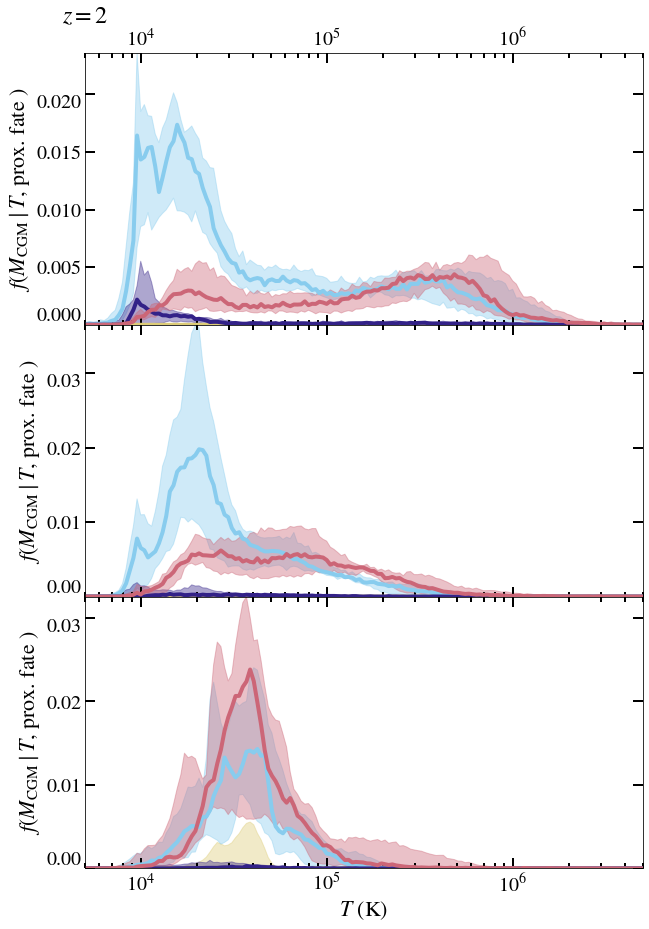

In [23]:
n_rows = len( mass_bins )

fig = plt.figure( figsize=(10,5*n_rows), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1, )
gs.update(wspace=0.025, hspace=0.0001)

norm_masses = data['M']['is_in_CGM'].sum()

for i, mass_bin in enumerate( mass_bins ):
    
    ax = plt.subplot( gs[i,0] )
    
    maxes = []

    for j, classification in enumerate( plot_classification_list ):

        sub_data = data['T'][classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        sub_masses = data['M'][classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]

        # Get the histograms out
        hists = verdict.Dict( {} )
        for sim_name in sub_data.keys():

            hists[sim_name], bins = np.histogram(
                sub_data[sim_name],
                bins = bins,
                weights = sub_masses[sim_name],
            )

            hists[sim_name] /= norm_masses[sim_name]

        # Plot actual lines
        x_arr = ( bins[:-1] + 0.5*( bins[1] - bins[0] ) )
        h_arr = hists.array()  
        ax.plot(
            x_arr,
            np.nanmedian( h_arr, axis=0 ),
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            linewidth = 4,
        )
        upper_percentile = np.nanpercentile( h_arr, 84, axis=0 )
        ax.fill_between(
            x_arr,
            np.nanpercentile( h_arr, 16, axis=0 ),
            upper_percentile,
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            alpha = 0.4,
        )
        
        maxes.append( upper_percentile.max() )

    ax.set_xscale( 'log' )
    ax.set_xlim( 5e3, 5e6 )
    ax.set_ylim( 0, np.array( maxes ).max() )
    
    # Labels
    ax.set_xlabel( r'$T$ (K)', fontsize=22 )
    ax.set_ylabel( r'$f(M_{\rm CGM} \mid T$, prox. fate $)$', fontsize=22, )

    # Hide some axis labels
    if not ax.is_last_row():
        ax.tick_params( labelbottom = False )
    if ax.is_first_row():
        ax.tick_params( labeltop = True )
        
    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-2].set_verticalalignment( 'top' )

    # Plot label
    if ax.is_first_row():
        ax.annotate(
            s = r'$z=' + '{:.02g}'.format( w.redshift.values[ind] ) + '$',
            xy = ( 0.0, 1.0 ),
            xytext = ( 0., 25., ),
            xycoords = 'axes fraction',
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'bottom',
            fontsize = 24,
        )

    # Adjust tick parameters
    ax.tick_params( direction='in', which='both', top=True, right=True )
    
# # Add labels
# line_label_args = {
#     '465': {
#         'is_CGM_accreted': {
            
#         }
#     }
# }
# for key, item in line_label_args[snum]:

#     text = ax.annotate( **item )

#     text.set_path_effects([
#         path_effects.Stroke(
#             linewidth=3, 
#             foreground=l_config.COLORSCHEME[key],
#             alpha = 0.5,
#         ),
#         path_effects.Normal(),
#     ])

fig